

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 100)          200000    
                                                                 
 simple_rnn (SimpleRNN)      (None, 128)               29312     
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dense_1 (Dense)             (None, 8)                 520       
                                                                 
Total params: 238088 (930.03 KB)
Trainable params: 238088 (930.03 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


RNN: Average Accuracy = 0.94
120/120 [==============================] - 1s 9ms/step


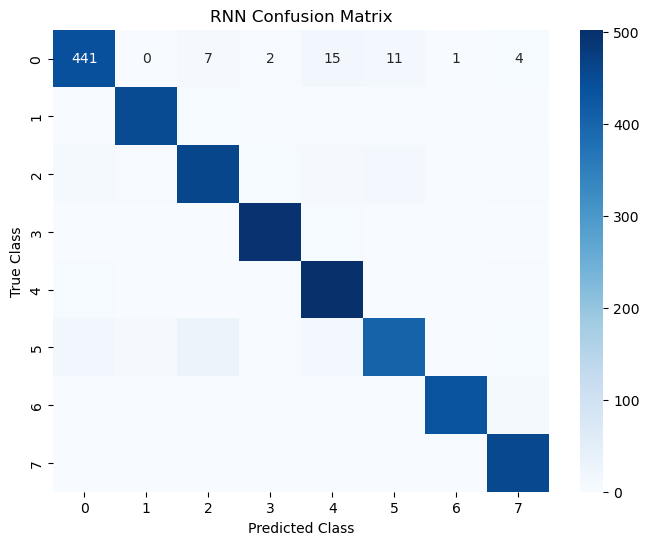

RNN Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.92      0.93       481
           1       0.98      0.99      0.98       457
           2       0.92      0.93      0.92       494
           3       0.98      0.99      0.98       501
           4       0.93      0.98      0.96       510
           5       0.95      0.85      0.90       474
           6       1.00      0.98      0.99       442
           7       0.95      1.00      0.98       456

    accuracy                           0.95      3815
   macro avg       0.96      0.95      0.95      3815
weighted avg       0.95      0.95      0.95      3815



In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report, confusion_matrix

# Load the dataset
df = pd.read_csv('R2_ChatGPt_dataset.csv', encoding='latin1')

# Preprocessing the text data
def clean_text(text):
    if not isinstance(text, str):
        return ""
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    stop_words = set(stopwords.words('english'))
    tokens = text.split()
    filtered_tokens = [token for token in tokens if token not in stop_words]
    text = ' '.join(filtered_tokens)
    lemmatizer = WordNetLemmatizer()
    tokens = text.split()
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]
    text = ' '.join(lemmatized_tokens)
    return text

# Apply the clean_text function to the text column
df['Base_Reviews'] = df['Base_Reviews'].apply(clean_text)

# Define labels dictionary and filter the dataset
y_dict = {'anger': 0, 'confusion': 1, 'disappointment': 2, 'distrust': 3, 'disgust': 4, 'frustration': 5, 'fear': 6, 'sadness': 7}
df = df[df['category'].isin(y_dict.keys())]

# Prepare data for training
X = df['Base_Reviews'].values
y = [y_dict[item] for item in df['category'].values]
num_classes = len(np.unique(y))
y = keras.utils.to_categorical(y, num_classes)

# Tokenization and padding
max_features = 2000
maxlen = 100
tokenizer = Tokenizer(num_words=max_features, split=' ')
tokenizer.fit_on_texts(X)
X = tokenizer.texts_to_sequences(X)
X = pad_sequences(X, maxlen=maxlen)

# Oversampling to balance the dataset
oversampler = RandomOverSampler(random_state=42)
X_resampled, y_resampled = oversampler.fit_resample(X, y)

# RNN Model definition
rnn_model = keras.models.Sequential([
    keras.layers.Embedding(max_features, 100, input_length=maxlen),
    keras.layers.SimpleRNN(128, dropout=0.2, recurrent_dropout=0.2),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(num_classes, activation='softmax')
])

# Compile the model
optimizer = keras.optimizers.Adam(learning_rate=0.001)
rnn_model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
rnn_model.summary()

# K-fold cross-validation
k = 10
kf = KFold(n_splits=k, shuffle=True, random_state=42)
rnn_acc_scores = []
rnn_history_list = []

for train_index, test_index in kf.split(X_resampled):
    X_train, X_test = X_resampled[train_index], X_resampled[test_index]
    y_train, y_test = y_resampled[train_index], y_resampled[test_index]
    rnn_history = rnn_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=128, verbose=0)
    rnn_history_list.append(rnn_history)
    rnn_loss, rnn_acc = rnn_model.evaluate(X_test, y_test, verbose=0)
    rnn_acc_scores.append(rnn_acc)

# Output average accuracy
avg_rnn_acc = np.mean(rnn_acc_scores)
print("RNN: Average Accuracy = {:.2f}".format(avg_rnn_acc))

# Generate and visualize the confusion matrix
rnn_pred = np.argmax(rnn_model.predict(X_test), axis=-1)
rnn_cm = confusion_matrix(np.argmax(y_test, axis=-1), rnn_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(rnn_cm, annot=True, fmt='d', cmap='Blues')
plt.title('RNN Confusion Matrix')
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.show()

# Classification report
rnn_report = classification_report(np.argmax(y_test, axis=-1), rnn_pred)
print("RNN Classification Report:\n", rnn_report)


